Should I Collect More Data?
===

Author: Nathan A. Mahynski

Date: 2023/09/12

Description: How do I know if more data will help me or not?

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/api/learning_curves.ipynb)

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [1]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import sklearn
import imblearn

import numpy as np

from pychemauth.classifier.simca import SIMCA_Authenticator

from sklearn.model_selection import train_test_split, LearningCurveDisplay, RepeatedStratifiedKFold, GridSearchCV

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

numpy     : 1.24.3
sklearn   : 1.3.0
pychemauth: 0.0.0b4
watermark : 2.4.3
imblearn  : 0.11.0
matplotlib: 3.7.2



<h3>Load the Data</h3>

In [4]:
from sklearn.datasets import load_wine as load_data
X, y = load_data(return_X_y=True, as_frame=True)

In [5]:
# Here we have 3 different classes of wine
np.unique(y)

array([0, 1, 2])

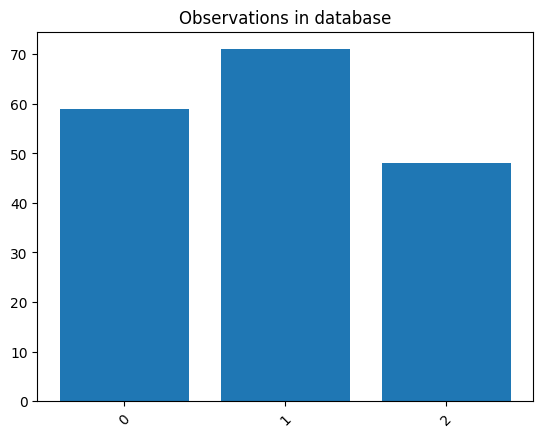

In [6]:
plt.bar(
    x=np.unique(y),
    height=[np.sum(y == class_) for class_ in np.unique(y)]
)
plt.xticks([0, 1, 2])
plt.title('Observations in database')
_ = plt.xticks(rotation=45)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values, # Let's try to predict the salary based on the other numerical features.
    shuffle=True,
    random_state=42,
    test_size=0.2,
    stratify=y # It is usually important to balance the test and train set so they have the same fraction of classes
)

Learning Curves
---

[Learning curves](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#learning-curve) illustrate the effect of collecting more data to use during the training process.  Data is often scarce and can be expensive to collect, but learning curves help you extrapolate a model's performance as if you *did* collect more data.  This means we can estimate the value produced (degree of model improvement) for a given investment (cost to collect more data).

In practice, this is done by training on small subsets of your data, of progressively increasing size, until you reach all your available data.  This way, you build a curve from the small(er) data limit up to your current capacity and hopefully can extrapolate the results. For each subset of data, some form of CV is performed to get a mean and standard deviation (uncertainty) from the test folds.  This what is reported below.

<h3>Extrapolating Model Performance</h3>

In [24]:
compliant = SIMCA_Authenticator(
    n_components=2,
    alpha=0.05,
    scale_x=True,
    style='dd-simca',
    robust="semi",
    sft=False,
    target_class=0, # Let's model class 0
    use='compliant' # Using a compliant approach will use the other classes provided at training time
)

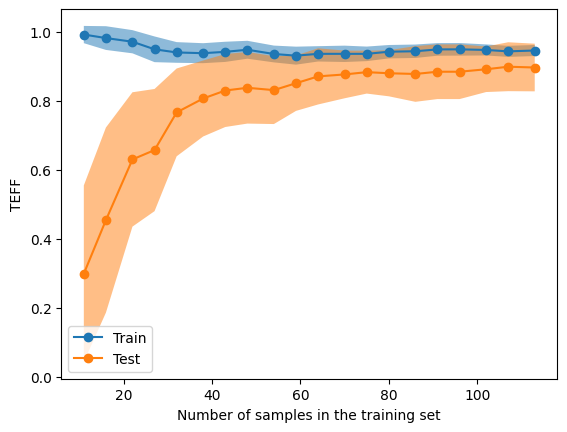

In [25]:
common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 20),
    "cv": RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
    "score_type": "both", # Get both test and train results
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "TEFF",
}

# This test how this specific model performs as more and more data is provided,
# i.e., the model with the hyperparameters specified above.
res = LearningCurveDisplay.from_estimator(compliant, **common_params)

In [26]:
# Let's extract the test curve and fit this
x, y = res.lines_[1].get_xdata(), res.lines_[1].get_ydata()

from scipy.optimize import curve_fit

# Define a functional form to fit the curve to.
# This is convenient because the `limit` term represents the limiting
# performance we can achieve so we can just look at the best fit answer to
# predict our extrapolated performance.
def curve(x, x0, a, b, c, limit):
    return limit - (a * np.exp(-b * (x - x0) + c))

popt, pcov = curve_fit(
    curve,
    x,
    y,
    p0=[0, 1, 0.05, 0, 1.0] # Initial guess for parameters
)

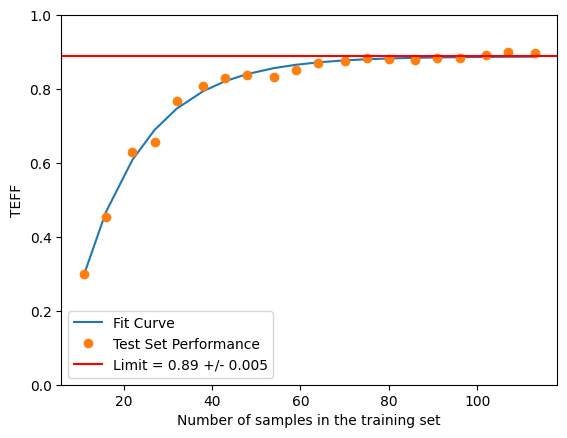

In [27]:
plt.plot(x, curve(x, *popt), label='Fit Curve')
plt.plot(x, y, 'o', color='C1', label='Test Set Performance')

# See https://docs.scipy.org/doc/scipy-1.13.1/reference/generated/scipy.optimize.curve_fit.html.
plt.axhline(
    popt[-1],
    color='r',
    label=f'Limit = {"%.2f"%popt[-1]} +/- {"%.3f"%(np.sqrt(np.diag(pcov))[-1])}' # This gives +/- 1 standard deviation on the parameter estimate.
)
plt.ylim(0, 1)
plt.xlabel('Number of samples in the training set')
plt.ylabel('TEFF')
_ = plt.legend(loc='best')

Unsurprisingly, this model performs quite well and the train and test performances have slowly converged.  More data could possibly push this convergence further, but it seems to have essentially reached a plateau.

👉 What is more important to consider, though, is that we have not considered how this would change if we chose different hyperparameters!

<h3>Incorporating Hyperparameter Search Uncertainty</h3>

But what if we need to optimize the hyperparameters, too?  We should use a nested CV approach to examine the uncertainty in the determination of those hyperparameters.  In this case, the model is optimized with (presumably different) hyperparameters at each data fraction considered.  Overall, this tells you how the overall modeling procedure (if you were using a pipeline) performs as more data becomes available.  

* You can expect that a model with enough flexilibity (variance) to adapt to more data would continue to perform better and better as more data as added assuming that is appropriately cross-validated internally to prevent overfitting.

* A model with a high bias can only benefit from more data up to a certain point and will plateau to a much lower value with much less data by comparison.

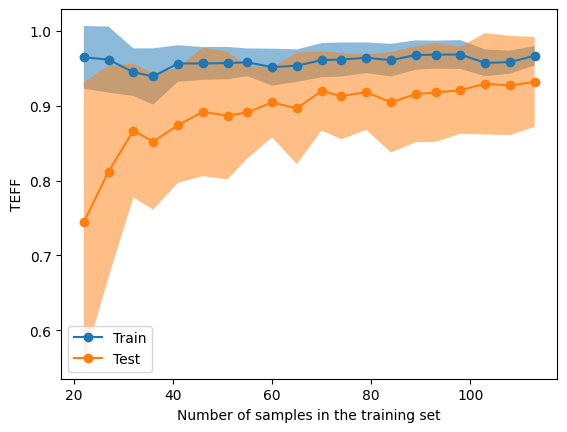

In [16]:
k_inner = 5
k_outer = 5 # 10 would be better, but for demonstration we will use a smaller number
n_repeats = 5 # 10 would be better, but for demonstration we will use a smaller number

compliant_pipeline = imblearn.pipeline.Pipeline(
    steps=[
        ("simca", SIMCA_Authenticator(
            n_components=1,
            alpha=0.05,
            scale_x=True,
            style='dd-simca',
            robust="semi",
            sft=False,
            target_class=0,
            use='compliant'
        )
    )
])

param_grid = [{
    'simca__n_components':np.arange(1, 4),
    'simca__alpha': [0.01, 0.03, 0.05],
}]

gs = GridSearchCV(
    estimator=compliant_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=k_inner, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.2, 1.0, 20), # Be sure to consider how low you can go with this (see below)
    "cv": RepeatedStratifiedKFold(n_repeats=n_repeats, n_splits=k_outer, random_state=0),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "TEFF",
}

res = LearningCurveDisplay.from_estimator(gs, **common_params)

When nesting cross-validators like this we should think a little bit about how much data is available at each point in the learning curve. In this example, k_outer splits are repeatedly (`n_repeat` times) used to estimate uncertainty on the data it is given.  This means a fraction of (k_outer-1)/k_outer are available for training; this is further subdivided by the inner k-fold CV used to optimize the pipeline's hyperparameter.

We need to ensure that the test fold of the inner loop has at least 1 sample of each class.  Thus, with k_inner = 5 we need to have at least 5 examples in each outer training loop so there is atleast 1 sample in the inner test set. Note that since we are using stratified splitters a warning will be thrown if an even split cannot be made, which will be set off by the class with the least observations over all (in this case it is actually class 2).

The first data fraction tested above uses 20% of the available data (`"train_sizes": np.linspace(0.2, ...)`).  We can test that this lower bound will still work with the following logic.



In [22]:
min_fraction = 0.2
minority_class = 2

np.sum(y_train == minority_class)*min_fraction*(k_outer-1)/(k_outer) > k_inner

True

Observe the following trends:
* The uncertainty is much higher now because we are also incorporating the hyperparameter search (above)
* The final performance value is also higher because a better set of hyperparamters could be found (below)
* The performance at smaller data fraction is also generally higher for the same reason (below)

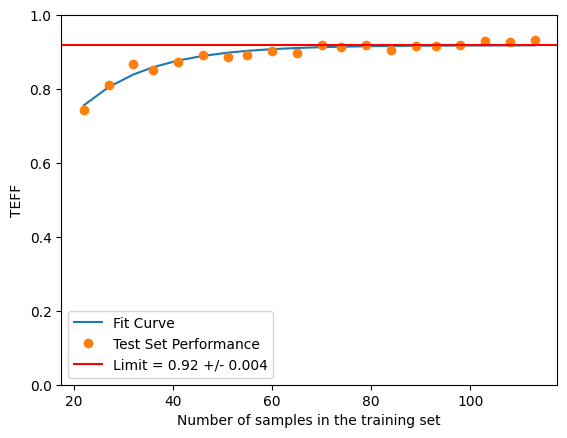

In [23]:
# Let's extract the test curve and fit this
x, y = res.lines_[1].get_xdata(), res.lines_[1].get_ydata()

popt, pcov = curve_fit(
    curve,
    x,
    y,
    p0=[0, 0.1, 0.01, 0, 1.0]
)

plt.plot(x, curve(x, *popt), label='Fit Curve')
plt.plot(x, y, 'o', color='C1', label='Test Set Performance')

# See https://docs.scipy.org/doc/scipy-1.13.1/reference/generated/scipy.optimize.curve_fit.html.
plt.axhline(
    popt[-1],
    color='r',
    label=f'Limit = {"%.2f"%popt[-1]} +/- {"%.3f"%(np.sqrt(np.diag(pcov))[-1])}' # This gives +/- 1 standard deviation on the parameter estimate.
)
plt.ylim(0, 1)
plt.xlabel('Number of samples in the training set')
plt.ylabel('TEFF')
_ = plt.legend(loc='best')